# Diffuse scattering of the triangular and honeycomb lattice

Here we use the self-consistent Gaussian approximation (SCGA) to calculate the
diffuse scattering pattern for honeycomb and triangular lattice spin systems.
As demonstrated by J. Paddison in
[Phys. Rev. Lett. **125**, 247202 (2020)](https://doi.org/10.1103/PhysRevLett.125.247202)
diffuse scattering in the paramagnetic regime can contain signatures of bond-dependent
exchange interactions.

To demonstrate the use of SCGA, in this tutorial, we reproduce the results of
[Paddison](https://doi.org/10.1103/PhysRevLett.125.247202).

In [1]:
using Sunny, GLMakie, LinearAlgebra
units = Units(:meV,:angstrom);

### Triangular lattice

Let us attempt to recreate the first plot in Figure 2 from
[Phys. Rev. Lett. **125**, 247202 (2020)](https://doi.org/10.1103/PhysRevLett.125.247202), the
calculation for the triangular lattice in the $(hk0)$ plane using the
antiferromagnetic (AFM) Heisenberg model.

First, create the crystal structure. We choose space group $\# 143$ so that
the crystal has $C_3$ rotational symmetry.

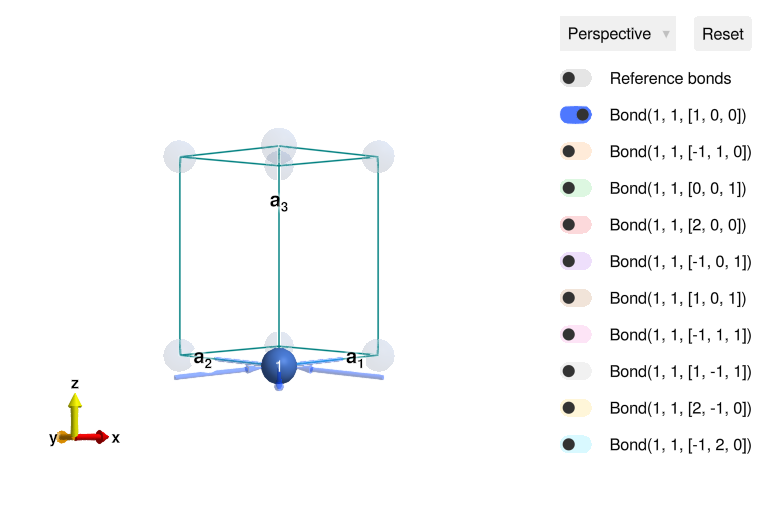

In [2]:
latvecs = lattice_vectors(3.464,3.464,6,90,90,120)
positions = [[0,0,0]]
cryst = Crystal(latvecs, positions, 143)
view_crystal(cryst)

We then set the `Moment` on each site and set the exchanges.
The nearest-neighbour (NN) spin Hamiltonian from [Phys. Rev. Lett. **125**, 247202 (2020)](https://doi.org/10.1103/PhysRevLett.125.247202)
takes the form:

$$ J =
\begin{pmatrix}
  J_x+J_a \cos(ϕ)       & -J_a \sin(ϕ)          & -\sqrt{2} J_b \cos(ϕ) \\
  -J_a \sin(ϕ)          & J_x-J_a \cos(ϕ)       & -\sqrt{2} J_b \sin(ϕ) \\
  -\sqrt{2} J_b \cos(ϕ) & -\sqrt{2} J_b \sin(ϕ) & J_z
\end{pmatrix}
$$

Due to the capabilities of Sunny to populate surrounding bonds by symmetry,
we can simply set the exchange matrix of the $ϕ=0$ bond using `set_exchange!`.

As we are focusing on the AFM Heisenberg model, we set $J_a, J_b = 1$
and $J_a, J_b = 0$.

Note, the axes defined by [Paddison](https://doi.org/10.1103/PhysRevLett.125.247202)
are flipped in $x$ and $y$ compared to our crystal structure defined by Sunny.
Therefore, we swap the $x$ and $y$ components of the matrix here and set the
$ϕ=0$ bond to be along `Bond(1,1,[1,0,0])` (along $x$ in our system).
A good sanity check is to `view_crystal` and verify that the exchange matrix for each bond
matches those specified by the general expression above for  $ϕ = 0, \pm 2\pi/3$ values.
Hover over each bond in the interactive [GLMakie](https://docs.makie.org/)
plot to view each exchange matrix.

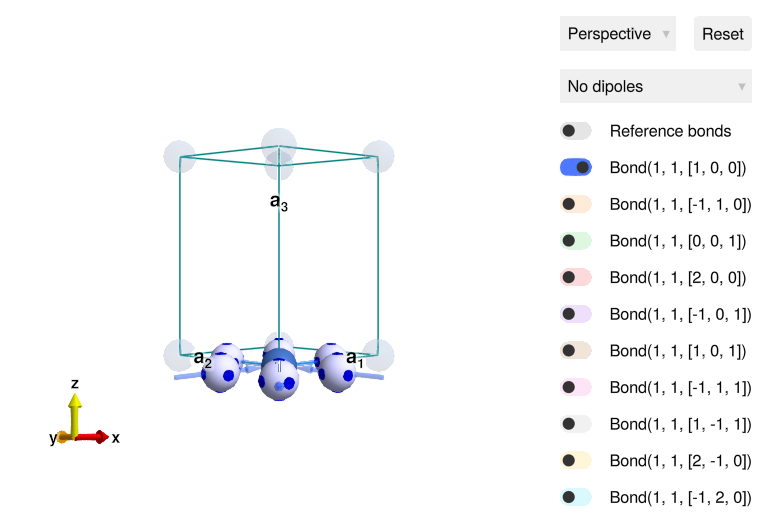

In [3]:
spininfos = [1 => Moment(; s=1, g=2)]
sys = System(cryst, spininfos, :dipole);
Jx, Jz, Ja, Jb = [1,1,0,0]
Js = diagm([Jx,Jx,Jz]) + diagm([-Ja,Ja,0]) - [0 0 0; 0 0 Jb*sqrt(2); 0 Jb*sqrt(2) 0]
set_exchange!(sys, Js, Bond(1,1,[1,0,0]))
view_crystal(sys)

We also include an arbitrary magnetic `FormFactor`.

In [4]:
formfactors = [1 => FormFactor("Yb3")]
measure = ssf_perp(sys; formfactors);

Use the output of `SCGA` to calculate `intensities_static`
in a given reciprocal-space plane. To plot the $(hk0)$ plane, choose two
orthogonal vectors, $[1,-1/2,0]$ and $[1,0,0]$. Plot into an `Axis` using
[GLMakie](https://docs.makie.org/dev/reference/blocks/axis). This will allow
for iterative plotting within loops, which will be useful for recreating the
entirety of [Figure 2](https://doi.org/10.1103/PhysRevLett.125.247202).

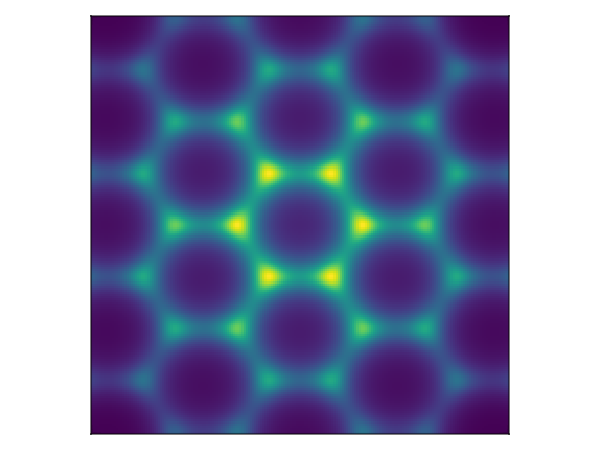

In [5]:
scga =  SCGA(sys; measure, kT=1, dq=0.1)
grid = q_space_grid(cryst, [1,-1/2,0], range(-2.2,2.2,200), [0,1,0], range(-2,2,200))
res = intensities_static(scga, grid)

fig = Figure()
ax = Axis(fig[1, 1], aspect = 1)
heatmap!(ax, reshape(res.data, (200,200)))
hidedecorations!(ax)
fig

### Honeycomb lattice

The same methodology can be followed for the honeycomb lattice.

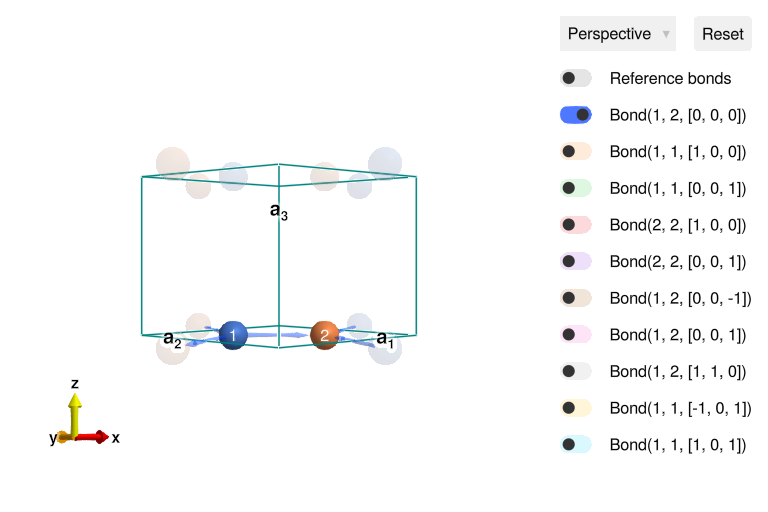

In [6]:
latvecs    = lattice_vectors(6,6,6,90,90,120)
positions  = [[1/3,2/3,0],[2/3,1/3,0]]
cryst = Crystal(latvecs, positions, 143)
view_crystal(cryst)

As we now have two atoms per unit cell, set the `Moment` for both of these.
In the case of the honeycomb lattice, our axes match that of
[Paddison](https://doi.org/10.1103/PhysRevLett.125.247202), therefore
there is no requirement to switch $x$ and $y$. Here, the $ϕ=0$ bond
is `Bond(1,2,[0,1,0])`.

In [7]:
spininfos = [1 => Moment(; s=1, g=2),2 => Moment(; s=1, g=2)]
sys = System(cryst, spininfos, :dipole);

We choose a different parameter set in this case, corresponding to a ferromagnetic
Kitaev model with $K=2$.
The $Q$ dependence of the diffuse scattering intensity originates from
the $Q$ dependence of the exchange matrix, $J(Q)$. It can therefore be
instructive to examine the symmetry of the exchange matrices. This can be done
with `view_crystal` by passing an `System` object.

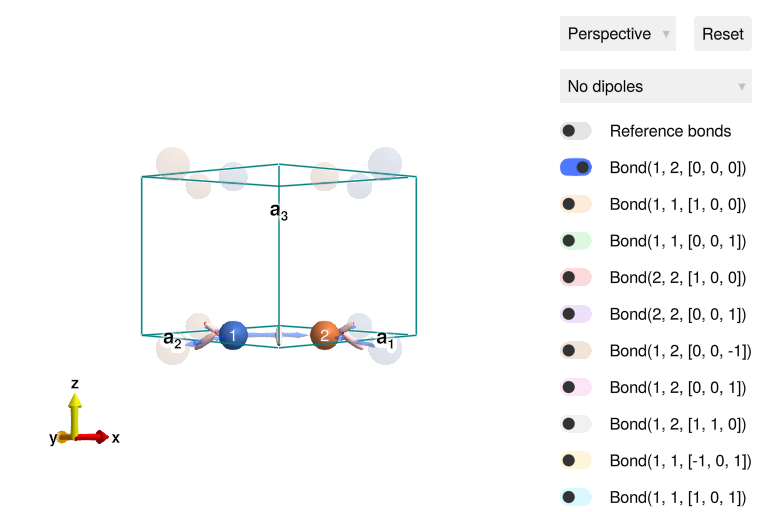

In [8]:
Jx, Jz, Ja, Jb = [-2/3,-2/3,-2/3,-2/3]
Js = diagm([Jx,Jx,Jz]) + diagm([Ja,-Ja,0]) - [0 0 Jb*sqrt(2); 0 0 0; Jb*sqrt(2) 0 0]
set_exchange!(sys, Js, Bond(1,2,[0,1,0]))
view_crystal(sys)

The exchange matrix is represented as an elipsoid. For this parameterization, the
elipsoids are oriented with components along the the $[001]$ and $\xi = [1,0,0], [0,1,0]$ or $[1,1,0]$
directions.

We once again set our `FormFactor`, calculate our
`intensities_static` and plot into an `Axis`. In this case
the pattern in the $(hhl)$ plane reflects the symmetry of $J(Q)$.

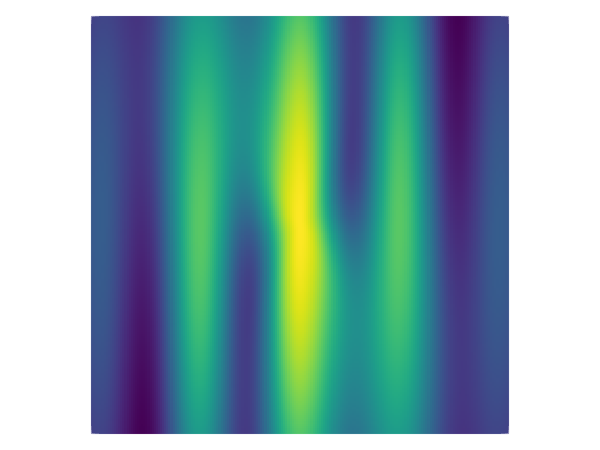

In [9]:
formfactors = [1 => FormFactor("Yb3"), 2 => FormFactor("Yb3")]
measure = ssf_perp(sys; formfactors)
scga =  SCGA(sys; measure, kT=1, dq=0.1)
grid = q_space_grid(cryst, [1,1,0], range(-2,2,200), [0,0,1], range(-2,2,200))
res = intensities_static(scga, grid)

fig = Figure()
ax = Axis(fig[1, 1], aspect = 1)
heatmap!(ax,reshape(res.data, (200,200)))
hidedecorations!(ax)
hidespines!(ax)
fig

### Powder average

Collecting neutron scattering data for single crystal samples may not
always be feasible. In this instance, a powder sample may be used instead.
Calculate the `powder_average` of the structure factor intensities
and plot the output. We will later see that the interactions may still be
determined in certain cases for powder-averaged data.

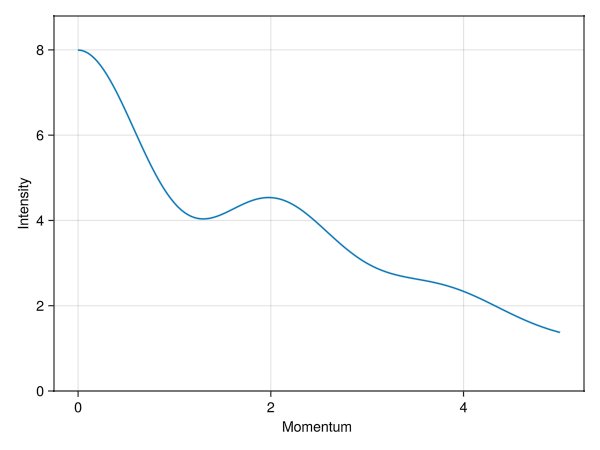

In [10]:
radii = range(0.0, 5.0, 200)
res = powder_average(cryst, radii, 500) do qs
    intensities_static(scga, qs)
end


plot_intensities(res)

### Comparison with literature
For completeness, we performed calculations for each of the seven models described by
[Paddison](https://doi.org/10.1103/PhysRevLett.125.247202) with varying
$(J_x,J_z,J_a,J_b)$ values: the AFM Heisenberg $(1,1,0,0)$
and Ising $(0,1,0,0)$ models, the AFM Heisenberg model with varying $J_a$
$(1,1,\pm 1,0)$ and $J_b$ $(1,1,0,\pm \frac{3}{4})$ values, and the
ferromagnetic Kitaev model $(\pm \frac{2}{3},\pm \frac{2}{3},\pm \frac{2}{3},\pm \frac{2}{3})$.
To allow for easier comparison of intensities, plots (iii)-(vii) for the
triangular lattice are calculated at a higher temperature.

<img width="75%" src="full_honeycomb_tri_figure.jpg">

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*